In [1]:
import findspark
findspark.init()
import pyspark 
from pyspark import SparkContext

In [2]:
config = pyspark.SparkConf().set('spark.executor.memory', '8G').set('spark.cores.max', '8')\
            .set('spark.port.maxRetries','200') 
sc = pyspark.SparkContext(appName="Project 1", master='spark://polyp1:7077',conf = config )

In [3]:
dataHeader = sc.textFile("/scratch/ISE495/2017_project_01/header.txt")

In [4]:
data = sc.textFile("/scratch/ISE495/2017_project_01/green_tripdata_2015-09.csv")
#data = sc.textFile("/scratch/ISE495/2017_project_01/green_tripdata_2015-09_small.csv")

print data.take(1)

[u'2,2015-09-01 00:02:34,2015-09-01 00:02:38,N,5,-73.979484558105469,40.684955596923828,-73.97943115234375,40.685020446777344,1,.00,7.8,0,0,1.95,0,,0,9.75,1,2']


In [5]:
""" Q1 """

def split_line(e):
    return e.split(',')

datafile = data.map(split_line)
# The datafile will be used in later questions as original splitted file.

Header = dataHeader.map(split_line).flatMap(lambda x: x)
print "There are " + str(data.count()) + " rows and " +str(Header.count()) + " colunms in data file."

There are 1494926 rows and 21 colunms in data file.


In [ ]:
""" Q2 """

"""
Since there are about 1.5 million records, there could be several methods for this problem.
1) reduce the data as a preprocess and then output and plot by EXCEL.
2) define a bin-range, and calculate the frequency for each bin. 

"""
trip_distance_data = datafile.map(lambda x: x[10]).map(lambda x: (float(x),1)).reduceByKey(lambda x,y: x+y).sortByKey()

#trip_distance_value = trip_distance_data.map(lambda x: x[0]).collect()
#trip_distance_number = trip_distance_data.map(lambda x: x[1]).collect()

#with open("distance value.csv", "w") as output:
#    output.write(str(trip_distance_value))

#with open("distance number.csv", "w") as output:
#    output.write(str(trip_distance_number))   

In [ ]:
"""Q2 Continue"""

# Choose the bin width based on frequency.

trip_data = trip_distance_data.collect()
Occurance = []
X_axis_left = []
X_axis_width = []
count = 0
i = 0.2
k = 0
j = 0
while i <= 100:
    while j <= len(trip_data):
        if k <= trip_data[j][0] < i:
            count = count + int(trip_data[j][1])
            j += 1
        else:
            Occurance.append(count)
            count = 0
            X_axis_left.append(float(k))
            if int(i) < 20:
                i += 0.2
                k += 0.2
                X_axis_width.append(0.2)
            elif int(i) == 20:
                i += 1
                k += 0.2
                X_axis_width.append(1)
                print (k,i)
            elif i > 20:
                i += 1
                k += 1
                X_axis_width.append(1)
            break

#print len(Occurance), Occurance
#print len(X_axis_left), X_axis_left
#print len(X_axis_width), X_axis_width

#with open("trip data_various bin width.csv", "w") as output:
#    output.write(str(Occurance)) 

In [ ]:
import matplotlib
import matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline 

x_modified_axis = []
for i in range(180):
    x_modified_axis.append(i)

plt.bar(X_axis_left[:50], Occurance[:50], width = X_axis_width[:50], color = 'b')
plt.show()

In [ ]:
"""Q3 Grouped by pick-up hour"""
#Calculate the mean trip distance of each hour for 30 days.
#Plot the mean trip distance versus day hour.

import datetime
import numpy as np

def kv_time_distance(e):
    dt = datetime.datetime.strptime(e[1], "%Y-%m-%d %H:%M:%S")
    return (dt.hour, float(e[10]))

time_distance = datafile.map(kv_time_distance)
mean_distance = time_distance.groupByKey().map(lambda m: [m[0],[x for x in m[1]]]).map(lambda m: [m[0],np.mean(m[1])]).takeOrdered(24, lambda value: value[0])
#print mean_distance

In [ ]:
"""Learn about datetime --> Extra Material"""

import datetime

string_date = '2015/9/2  12:02:34 AM'

dt = datetime.datetime.strptime('2015/9/2  9:02:34 AM', "%Y/%m/%d %I:%M:%S %p")
du = datetime.datetime.strptime('2015/9/1  11:01:09 PM', "%Y/%m/%d %I:%M:%S %p")
print du.hour

In [ ]:
"""Q3 continue"""

x = np.zeros(24)
y = np.zeros(24)
i = 0
for value in mean_distance:
    x[i] = value[0]
    y[i] = value[1]
    i += 1

print x
print y

plt.bar(x,y,width =1.0, color= 'r')
plt.show()

In [ ]:
"""Q4 Airport Area"""

# JFK longitude: -73.7757682800293 : -73.80748271942139
# JFK latitude: 40.640465334847704 : 40.66188943992171

# NEW longitude -74.17580366134644 : -74.1892147064209
# NEW latitude 40.68704909195378 : 40.6956396052937 

JFK_lon = [-73.7757682800293, -73.80748271942139]
JFK_lat = [40.640465334847704, 40.66188943992171]
NEW_lon = [-74.17580366134644, -74.1892147064209]
NEW_lat = [40.68704909195378, 40.6956396052937]

endCode_totalAmount = datafile.map(lambda e: (float(e[4]),float(e[18]))).reduceByKey(lambda x,y: x+y).sortByKey()
endCode_totalAmount_count = datafile.map(lambda e: (float(e[4]),1)).reduceByKey(lambda x,y: x+y).sortByKey()

fair = endCode_totalAmount.map(lambda x: x[1]).take(6)
count = endCode_totalAmount_count.map(lambda x: x[1]).take(6)
JFK_fair = fair[1]
NEW_fair = fair[2]
JFK_count = count[1]
NEW_count = count[2]
print datafile.map(lambda e: float(e[18])).take(5)
print "Average fair to JFK is " + str(JFK_fair/JFK_count)
print "Average fair to NEW is " + str(NEW_fair/NEW_count)

In [ ]:
print datafile.map(lambda x: (x[7], x[8])).take(1)

In [6]:
"""Q5 clustering pickup & drooff"""

#def add_location(x,y):
#    z = [0,0]
#    z[0] = x[0] + y[0]
#    z[1] = x[1] + y[1]
#    return z

count = datafile.count()
print count

pickup_location_long = datafile.map(lambda x: float(x[5]))
pickup_location_lat = datafile.map(lambda x: float(x[6]))
dropoff_location_long = datafile.map(lambda x: float(x[7]))
dropoff_location_lat = datafile.map(lambda x: float(x[8]))

sum_pickup_long = pickup_location_long.reduce(lambda x,y: x+y)
sum_pickup_lat = pickup_location_lat.reduce(lambda x,y: x+y)
sum_dropoff_long = dropoff_location_long.reduce(lambda x,y: x+y)
sum_dropoff_lat = dropoff_location_lat.reduce(lambda x,y: x+y)

average_pickup_long = sum_pickup_long / count
average_pickup_lat = sum_pickup_lat / count 
average_dropoff_long = sum_dropoff_long / count
average_dropoff_lat = sum_dropoff_lat / count

print [average_pickup_long, average_pickup_lat, average_dropoff_long, average_dropoff_lat]

def normalize_pickup(e):
    e[0] = e[0] / average_pickup_long
    e[1] = e[1] / average_pickup_lat
    return e

def normalize_dropoff(e):
    e[0] = e[0] / average_dropoff_long
    e[1] = e[1] / average_dropoff_lat
    return e

normalize_pickup_location = datafile.map(lambda x: [float(x[5]),float(x[6])]).map(normalize_pickup)
normalize_dropoff_location = datafile.map(lambda x: [float(x[7]),float(x[8])]).map(normalize_dropoff)

print normalize_pickup_location.take(1)

1494926
[-73.83083949411842, 40.69114448571891, -73.83727771386073, 40.69290536073598]
[[1.0020133194340677, 0.9998479057575476]]


In [11]:
"""Q5 Continue"""

from math import sqrt
from pyspark.mllib.clustering import KMeans, KMeansModel

error_list_pickup = []
error_list_dropoff = []
k_list = [2,4,6,8,10,12,14,16,18]
print "error_pickup", "error_dropoff"

for k in k_list:
    cluster_pickup = KMeans.train(normalize_pickup_location, k, maxIterations=10, initializationMode="random")
    cluster_dropoff = KMeans.train(normalize_dropoff_location, k, maxIterations=10, initializationMode='random')
    def error_pickup(point):
        center_pickup = cluster_pickup.centers[cluster_pickup.predict(point)]
        return sqrt(sum([x**2 for x in (point - center_pickup)]))
    def error_dropoff(point):
        center_dropoff = cluster_dropoff.centers[cluster_pickup.predict(point)]
        return sqrt(sum([x**2 for x in (point - center_dropoff)]))
    WSSSE_pickup = normalize_pickup_location.map(error_pickup).reduce(lambda x,y: x+y)
    WSSSE_dropoff = normalize_dropoff_location.map(error_dropoff).reduce(lambda x,y: x+y)
    error_list_pickup.append(WSSSE_pickup)
    error_list_dropoff.append(WSSSE_dropoff)
    print WSSSE_pickup, WSSSE_dropoff

error_pickup error_dropoff
2034.64275148 2085.21118204
798.594306511 643374.114716
668.716397642 398551.665225
599.262503947 161672.850226
465.760780351 296269.922282
408.517577885 134302.147395
419.134272834 306132.479798
387.41545872 128331.916772
337.268894797 73377.3544666


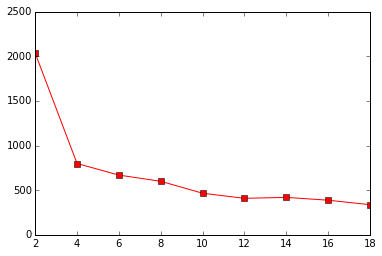

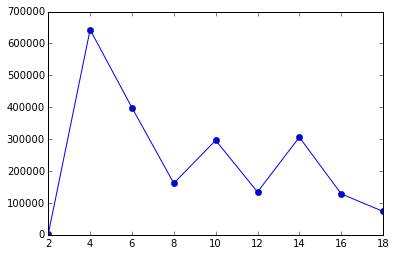

In [16]:
plt.plot(k_list,error_list_pickup,'rs-' )
plt.show()
plt.plot(k_list,error_list_dropoff, 'bo-')

# Based on error above, cluster with 18 centroids is the best choice.
# Maybe I should try more.

In [29]:
"""Q6 One clustering for pickup-dropoff"""

# One cluster includes all pickup and dropoff points. 
# Percentage of trips within a cluster is number of points divided by two.
# Since all points have a cluster number after training(clustering based on KMean or DBSCAN)
# compare cluster number for each pair stored in one feature data set as (pickup, dropoff)
# Assumption: no points have exact the same location --> union two data sets of point location.

# Normalize after union --> cannot use normalization result above.

import numpy as np
from math import sqrt
from pyspark.mllib.clustering import KMeans, KMeansModel
from sklearn.cluster import DBSCAN

pickup_location = datafile.map(lambda x: (float(x[5]),float(x[6])))
dropoff_location = datafile.map(lambda x: (float(x[7]),float(x[8])))
# Union pickup location points and dropoff location points.
all_points = pickup_location.union(dropoff_location)

count_data = datafile.count()
average_all_point_long = all_points.map(lambda e: e[0]).reduce(lambda x,y: x+y) / count_data
average_all_points_lat = all_points.map(lambda e: e[1]).reduce(lambda x,y: x+y) / count_data

normalized_all_points = all_points.map(lambda e: (e[0]/average_all_point_long, e[1]/average_all_points_lat))

# concatenate pickup and dropoff to test if they are in the same cluster. 
# the normalization should be the same as 'all_point' 
pickup_dropoff_pair = datafile.map(lambda x: [[float(x[5])/average_all_point_long,float(x[6])/average_all_points_lat],[float(x[7])/average_all_point_long,float(x[8])/average_all_points_lat]])


error_list_KMeans = []
ks = [10,12,14,16,18,20,22,24]

# KMean method for clustering
for k in ks:
    cluster_KMean = KMeans.train(normalized_all_points, k, maxIterations = 10, initializationMode = 'random')
    def error_KMeans(point):
        center_KMeans = cluster_KMean.centers[cluster_KMean.predict(point)]
        return sqrt(sum([x**2 for x in (point - center_KMeans)]))
    WSSSE_KMeans = normalized_all_points.map(error_KMeans).reduce(lambda x,y: x+y)
    error_list_KMeans.append(WSSSE_KMeans)
"""
for e in eps:
    cluster_DBSCAN = DBSCAN(e, min_samples = 10000).fit(all_points)
    def error_DBSCAN(point):
"""   

'\nfor e in eps:\n    cluster_DBSCAN = DBSCAN(e, min_samples = 10000).fit(all_points)\n    def error_DBSCAN(point):\n'

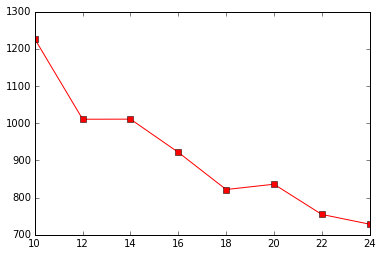

In [30]:
import matplotlib
import matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline 
plt.plot(ks,error_list_KMeans,'rs-')

In [34]:
# Final model of KMeans after selecting the number of clusters k = 24
cluster_KMean_final = KMeans.train(normalized_all_points, 24, maxIterations = 10, initializationMode = 'random')

In [39]:
# Report centroids in matrix form
centroids_KMeans = np.zeros([24,2])

for i in range(24):
    center = cluster_KMean_final.centers[i]
    centroids_KMeans[i][0] = center[0]
    centroids_KMeans[i][1] = center[1]
print centroids_KMeans

[[ 1.00143623  1.00329316]
 [ 1.00022251  1.0016706 ]
 [ 1.0014371   1.00270675]
 [ 1.00165259  1.00062558]
 [ 1.00098719  1.00416713]
 [ 1.00123276  1.00006507]
 [ 1.00116144  1.00177498]
 [ 1.00206099  1.00087326]
 [ 1.00138791  1.00374902]
 [ 1.00167233  0.99952195]
 [ 1.00097977  1.00324141]
 [ 1.00168787  1.00280801]
 [ 1.00183186  0.99829934]
 [ 1.00073391  1.00127376]
 [ 1.00181591  1.00234068]
 [ 1.00207521  0.99993668]
 [ 1.0002471   1.00363478]
 [ 0.99941844  0.99916093]
 [ 1.00180625  1.00152007]
 [ 1.00154158  1.00303278]
 [ 0.          0.        ]
 [ 0.99989638  1.00054156]
 [ 1.00157132  1.00229044]
 [ 1.0005473   1.00485457]]


In [40]:
# how many points belong to one cluster

points_KMeans_cluster = normalized_all_points.map(lambda point: cluster_KMean_final.predict(point)).map(lambda e: (e,1)).reduceByKey(lambda x,y: x+y)

[(0, 97028), (1, 110314), (2, 173831), (3, 247111), (4, 60418), (5, 128287), (6, 215378), (7, 78265), (8, 74656), (9, 244444), (10, 50933), (11, 158823), (12, 61820), (13, 283719), (14, 52301), (15, 359525), (16, 35618), (17, 28173), (18, 138566), (19, 114458), (20, 4073), (21, 124142), (22, 129468), (23, 18501)]


In [42]:
# Percentage of trips for each cluster 
# Count all points in a cluster means both pickup and dropoff are included, then divided by 2 get the average.

print points_KMeans_cluster.map(lambda e: (e[0],e[1]/2)).sortByKey().collect()

[(0, 48514), (1, 55157), (2, 86915), (3, 123555), (4, 30209), (5, 64143), (6, 107689), (7, 39132), (8, 37328), (9, 122222), (10, 25466), (11, 79411), (12, 30910), (13, 141859), (14, 26150), (15, 179762), (16, 17809), (17, 14086), (18, 69283), (19, 57229), (20, 2036), (21, 62071), (22, 64734), (23, 9250)]


In [48]:
# Percentage of trips where pickup and dropoff are in same cluster
# '-1' represents a class in which pickup and dropoff points belong to different clusters

pickup_drop_KMeans_center_pair = pickup_dropoff_pair.map(lambda point: (cluster_KMean_final.predict(point[0]),cluster_KMean_final.predict(point[1])))
pickup_drop_sameCluster = pickup_drop_KMeans_center_pair.map(lambda e: (e[0],1) if e[0] == e[1] else (-1,1)).reduceByKey(lambda x,y: x+y)
print pickup_drop_sameCluster.sortByKey().collect()

[(-1, 954396), (0, 9584), (1, 17217), (2, 20096), (3, 53985), (4, 11962), (5, 15795), (6, 62135), (7, 403), (8, 10151), (9, 47742), (10, 7547), (11, 15844), (12, 13920), (13, 84097), (14, 1619), (15, 80325), (16, 8990), (17, 1175), (18, 9022), (19, 11557), (20, 524), (21, 38584), (22, 15380), (23, 2876)]


In [6]:
"""Q7 """

# Assign features to represent location of pickup and dropoff for NJ or NYC, '1' and '2' respectively.
# Assign features '11', '12', '21', '22' to represent trip type NJ->NJ, NJ->NYC, NYC->NJ, NYC->NJ
# Apply map to add these features at the end of dataset

location_dictionary = {}
location_dictionary[1] = 'NJ'
location_dictionary[2] = 'NYC'
print location_dictionary

ingredient = 1.323942
intersection = 138.669195

def pickup_feature(e):
    if e[1][1] >= (ingredient*e[1][0] + intersection):
        return [e, [1, e[1][2], e[1][3]]]
    elif e[1][1] < (ingredient*e[1][0] + intersection):
        return [e, [2, e[1][2], e[1][3]]]
    
def dropoff_feature(e):
    if e[1][2] >= (ingredient*e[1][1] + intersection):
        return [e, [e[1][0], 1]]
    elif e[1][2] < (ingredient*e[1][1] + intersection):
        return [e, [e[1][0], 2]]

def concatenate_feature(e):
    a = []
    for value in e[0]:
        a.append(value)
    a.append(e[1])
    return a

location_feature_draft = datafile.map(lambda e: [e, [float(value) for value in e[5:9]]]).map(pickup_feature).map(dropoff_feature)
location_feature_added = location_feature_draft.map(lambda e: [e[0][0][0], e[1]]).map(concatenate_feature)

print location_feature_added.take(1)


{1: 'NJ', 2: 'NYC'}
[[u'2', u'2015-09-01 00:02:34', u'2015-09-01 00:02:38', u'N', u'5', u'-73.979484558105469', u'40.684955596923828', u'-73.97943115234375', u'40.685020446777344', u'1', u'.00', u'7.8', u'0', u'0', u'1.95', u'0', u'', u'0', u'9.75', u'1', u'2', [2, 2]]]


In [7]:
# Association Rule --> time hour vs. intra/inter
# Group time hour as added feature --> Find association rule

import datetime

def time_feature(e):
    departure_time = datetime.datetime.strptime(e[1], "%Y-%m-%d %H:%M:%S")
    arrival_time = datetime.datetime.strptime(e[2], "%Y-%m-%d %H:%M:%S")
    return (e, departure_time.hour)

time_location_feature_added = location_feature_added.map(time_feature).map(concatenate_feature)
print time_location_feature_added.take(1)

def string_time_location(e):
    return str(e[0]) + "," + str(e[1][0]) + "-" + str(e[1][1])

time_location_feature = time_location_feature_added.map(lambda e: [e[-1], e[-2]]).map(string_time_location).map(lambda e: e.split(','))
print time_location_feature.take(1)

[[u'2', u'2015-09-01 00:02:34', u'2015-09-01 00:02:38', u'N', u'5', u'-73.979484558105469', u'40.684955596923828', u'-73.97943115234375', u'40.685020446777344', u'1', u'.00', u'7.8', u'0', u'0', u'1.95', u'0', u'', u'0', u'9.75', u'1', u'2', [2, 2], 0]]
[['0', '2-2']]


In [54]:
# plot the inter and intra versus time --> implicitly show the regulation
inter_time_list = []
intra_time_list = []

group_time_inter_intra = time_location_feature.map(lambda e: e[0] + "," + e[1]).map(lambda e: (e,1)).reduceByKey(lambda x,y: x+y)
print type(group_time_inter_intra)

def group_time_inter_intra_split(value):
    value_split = value[0].split(',')
    return (int(value_split[0]), value_split[1], value[1])

inter_intra_time_list = group_time_inter_intra.map(group_time_inter_intra_split).collect()

i = 0
while i < 24:
    count_inter = 0
    count_intra = 0
    for j in xrange(len(inter_intra_time_list)):
        if inter_intra_time_list[j][0] == i:
            if inter_intra_time_list[j][1] == '1-2' or inter_intra_time_list[j][1] == '2-1':
                count_inter += inter_intra_time_list[j][2]
            else:
                count_intra += inter_intra_time_list[j][2]
        else:
            pass
    inter_time_list.append(count_inter)
    intra_time_list.append(count_intra)
    i += 1

<class 'pyspark.rdd.PipelinedRDD'>


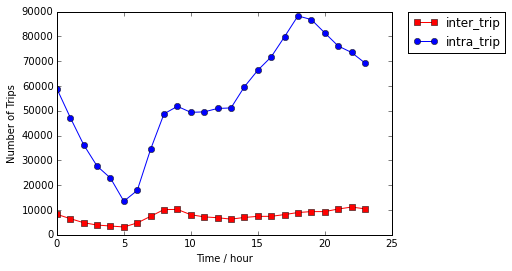

In [66]:
import numpy as np
import matplotlib
import matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline 

x = np.array(range(24))

plt.plot(x, inter_time_list, 'rs-', label ='inter_trip')
plt.plot(x, intra_time_list, 'bo-', label = 'intra_trip')

plt.xlabel('Time / hour')
plt.ylabel('Number of Trips')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [8]:
# Generate Frequent Itemset
from pyspark.mllib.fpm import FPGrowth

model_timeLocation = FPGrowth.train(time_location_feature, minSupport=0.01, numPartitions=10)
result_timeLocation = model_timeLocation.freqItemsets().collect()

for fi in result_timeLocation:
    print fi

FreqItemset(items=[u'1'], freq=53773)
FreqItemset(items=[u'1', u'2-2'], freq=38687)
FreqItemset(items=[u'16'], freq=79157)
FreqItemset(items=[u'16', u'1-1'], freq=27874)
FreqItemset(items=[u'16', u'2-2'], freq=43839)
FreqItemset(items=[u'2-2'], freq=864553)
FreqItemset(items=[u'15'], freq=73777)
FreqItemset(items=[u'15', u'1-1'], freq=26618)
FreqItemset(items=[u'15', u'2-2'], freq=39723)
FreqItemset(items=[u'1-1'], freq=449130)
FreqItemset(items=[u'7'], freq=41978)
FreqItemset(items=[u'7', u'1-1'], freq=17383)
FreqItemset(items=[u'7', u'2-2'], freq=17131)
FreqItemset(items=[u'2-1'], freq=144110)
FreqItemset(items=[u'2'], freq=41196)
FreqItemset(items=[u'2', u'2-2'], freq=30549)
FreqItemset(items=[u'0'], freq=67158)
FreqItemset(items=[u'0', u'2-2'], freq=46624)
FreqItemset(items=[u'1-2'], freq=37133)
FreqItemset(items=[u'14'], freq=66664)
FreqItemset(items=[u'14', u'1-1'], freq=23945)
FreqItemset(items=[u'14', u'2-2'], freq=35725)
FreqItemset(items=[u'18'], freq=97245)
FreqItemset(items

In [9]:
result_timeLocation_association = model_timeLocation.freqItemsets()

print model_timeLocation.freqItemsets().take(1)
print type(result_timeLocation)
print type(result_timeLocation_association)
print type(result_timeLocation_association.values())

sorted_result_timeLocation = model_timeLocation.freqItemsets().takeOrdered(40, lambda value: -value[1])
for value in sorted_result_timeLocation:
    print value

[FreqItemset(items=[u'1'], freq=53773)]
<type 'list'>
<class 'pyspark.rdd.PipelinedRDD'>
<class 'pyspark.rdd.PipelinedRDD'>
FreqItemset(items=[u'2-2'], freq=864553)
FreqItemset(items=[u'1-1'], freq=449130)
FreqItemset(items=[u'2-1'], freq=144110)
FreqItemset(items=[u'18'], freq=97245)
FreqItemset(items=[u'19'], freq=96141)
FreqItemset(items=[u'20'], freq=90785)
FreqItemset(items=[u'17'], freq=88022)
FreqItemset(items=[u'21'], freq=86543)
FreqItemset(items=[u'22'], freq=84705)
FreqItemset(items=[u'23'], freq=79795)
FreqItemset(items=[u'16'], freq=79157)
FreqItemset(items=[u'15'], freq=73777)
FreqItemset(items=[u'0'], freq=67158)
FreqItemset(items=[u'14'], freq=66664)
FreqItemset(items=[u'9'], freq=62027)
FreqItemset(items=[u'8'], freq=58965)
FreqItemset(items=[u'19', u'2-2'], freq=58904)
FreqItemset(items=[u'12'], freq=57828)
FreqItemset(items=[u'18', u'2-2'], freq=57487)
FreqItemset(items=[u'13'], freq=57477)
FreqItemset(items=[u'10'], freq=57468)
FreqItemset(items=[u'20', u'2-2'], fre

[53773, 38687, 79157, 27874, 43839, 864553, 73777, 26618, 39723, 449130, 41978, 17383, 17131, 144110, 41196, 30549, 67158, 46624, 37133, 66664, 23945, 35725, 97245, 30776, 57487, 62027, 25355, 26442, 96141, 27883, 58904, 31640, 23750, 90785, 24539, 56890, 26424, 19486, 58965, 24580, 24204, 22667, 57828, 21756, 29184, 88022, 29697, 50170, 57477, 20927, 30230, 86543, 21903, 54249, 16700, 84705, 19343, 54183, 57468, 23171, 26207, 56791, 21914, 27652, 79795, 16534, 52772]
[[u'1'], [u'1', u'2-2'], [u'16'], [u'16', u'1-1'], [u'16', u'2-2'], [u'2-2'], [u'15'], [u'15', u'1-1'], [u'15', u'2-2'], [u'1-1'], [u'7'], [u'7', u'1-1'], [u'7', u'2-2'], [u'2-1'], [u'2'], [u'2', u'2-2'], [u'0'], [u'0', u'2-2'], [u'1-2'], [u'14'], [u'14', u'1-1'], [u'14', u'2-2'], [u'18'], [u'18', u'1-1'], [u'18', u'2-2'], [u'9'], [u'9', u'1-1'], [u'9', u'2-2'], [u'19'], [u'19', u'1-1'], [u'19', u'2-2'], [u'3'], [u'3', u'2-2'], [u'20'], [u'20', u'1-1'], [u'20', u'2-2'], [u'4'], [u'4', u'2-2'], [u'8'], [u'8', u'1-1'], [u'8

In [67]:
# Generate Association Rule with confidence more than 0.8

freq_value_list = model_timeLocation.freqItemsets().values().collect()
freq_key_list = model_timeLocation.freqItemsets().keys().collect()

one_item_value = []
one_item_key_draft = []
one_item_key = []
more_item_value = []
more_item_key_draft = []
more_item_key = []

one_item_list = []
more_item_list = []
association_rule_Q7 = []

# Create time and association list
for i in range(len(freq_key_list)):
    if len(freq_key_list[i]) == 1:
        one_item_key_draft.append(freq_key_list[i])
        one_item_value.append(freq_value_list[i])
    else:
        more_item_key_draft.append(freq_key_list[i])
        more_item_value.append(freq_value_list[i])
        
# remove items that are not time from the one_item list
for key in one_item_key_draft:
    a = str(key)
    if a[4] == '-':
        key_index = one_item_key_draft.index(key)
        one_item_key_draft.remove(key)
        one_item_value.remove(one_item_value[key_index])
    else:
        pass
# change the type from string to int in one_item list
for key in one_item_key_draft:
    aa = str(key[0])
    bb = int(filter(str.isdigit, aa))
    one_item_key.append(bb)

for key in more_item_key_draft:
    flag_list = []
    for i in range(len(key)):
        cc = int(filter(str.isdigit, str(key[i])))
        flag_list.append(cc)
    more_item_key.append(flag_list)
        
# Create key-value pair for two lists, ready to be used for generating association rule
for i in range(len(one_item_key)):
    one_item_list.append([one_item_key[i], one_item_value[i]])
for j in range(len(more_item_key)):
    more_item_list.append([more_item_key[j], more_item_value[j]])
    
print one_item_list
print "------------------------------------------------------"
print more_item_list

for i in range(len(one_item_list)):
    for j in range(len(more_item_list)):
        if one_item_list[i][0] in more_item_list[j][0]:
            a = float(more_item_list[j][1]) / float(one_item_list[i][1])
            if 0.5 < a:
                b = str(one_item_list[i][0]) + "->" + str(more_item_list[j][0])
                association_rule_Q7.append([b, a])
            else:
                pass
        else:
            pass

print association_rule_Q7

[[1, 53773], [16, 79157], [15, 73777], [7, 41978], [2, 41196], [0, 67158], [14, 66664], [18, 97245], [9, 62027], [19, 96141], [3, 31640], [20, 90785], [4, 26424], [8, 58965], [6, 22667], [12, 57828], [17, 88022], [13, 57477], [21, 86543], [5, 16700], [22, 84705], [10, 57468], [11, 56791], [23, 79795]]
------------------------------------------------------
[[[1, 22], 38687], [[16, 11], 27874], [[16, 22], 43839], [[15, 11], 26618], [[15, 22], 39723], [[7, 11], 17383], [[7, 22], 17131], [[2, 22], 30549], [[0, 22], 46624], [[14, 11], 23945], [[14, 22], 35725], [[18, 11], 30776], [[18, 22], 57487], [[9, 11], 25355], [[9, 22], 26442], [[19, 11], 27883], [[19, 22], 58904], [[3, 22], 23750], [[20, 11], 24539], [[20, 22], 56890], [[4, 22], 19486], [[8, 11], 24580], [[8, 22], 24204], [[12, 11], 21756], [[12, 22], 29184], [[17, 11], 29697], [[17, 22], 50170], [[13, 11], 20927], [[13, 22], 30230], [[21, 11], 21903], [[21, 22], 54249], [[22, 11], 19343], [[22, 22], 54183], [[10, 11], 23171], [[10, 

Q7 Answers
1. From the result above, from 22:00 to 4:00, more people are likely to go from NYC to NYC
2. 



In [6]:
"""Q8 Problem - Demand vs. Time""" 
# group time, cluster each time, find the dense area

import datetime
import numpy as np

def pickup_time_location(e):
    departure_time = datetime.datetime.strptime(e[1], "%Y-%m-%d %H:%M:%S")
    return (departure_time.hour, [float(e[5]), float(e[6])])

data_hour = datafile.map(pickup_time_location).groupByKey().sortByKey().map(lambda e: (e[0], [x for x in e[1]]))

In [7]:
# apply filter to find hour-data instead of groupByKey
# Since the calculation limit, only take 3 hours as example

data_kmeans_list = []

"""
data_hour_filter_0 = datafile.map(pickup_time_location).filter(lambda e: e[0] == 0).map(lambda e: e[1])
data_hour_filter_1 = datafile.map(pickup_time_location).filter(lambda e: e[0] == 1).map(lambda e: e[1])
data_hour_filter_2 = datafile.map(pickup_time_location).filter(lambda e: e[0] == 2).map(lambda e: e[1])
data_hour_filter_3 = datafile.map(pickup_time_location).filter(lambda e: e[0] == 3).map(lambda e: e[1])
data_hour_filter_4 = datafile.map(pickup_time_location).filter(lambda e: e[0] == 4).map(lambda e: e[1])
data_hour_filter_5 = datafile.map(pickup_time_location).filter(lambda e: e[0] == 5).map(lambda e: e[1])
data_hour_filter_6 = datafile.map(pickup_time_location).filter(lambda e: e[0] == 6).map(lambda e: e[1])
data_hour_filter_7 = datafile.map(pickup_time_location).filter(lambda e: e[0] == 7).map(lambda e: e[1])
data_hour_filter_8 = datafile.map(pickup_time_location).filter(lambda e: e[0] == 8).map(lambda e: e[1])
data_hour_filter_9 = datafile.map(pickup_time_location).filter(lambda e: e[0] == 9).map(lambda e: e[1])
data_hour_filter_10= datafile.map(pickup_time_location).filter(lambda e: e[0] == 10).map(lambda e: e[1])
data_hour_filter_11= datafile.map(pickup_time_location).filter(lambda e: e[0] == 11).map(lambda e: e[1])
data_hour_filter_12= datafile.map(pickup_time_location).filter(lambda e: e[0] == 12).map(lambda e: e[1])
data_hour_filter_13= datafile.map(pickup_time_location).filter(lambda e: e[0] == 13).map(lambda e: e[1])
data_hour_filter_14= datafile.map(pickup_time_location).filter(lambda e: e[0] == 14).map(lambda e: e[1])
data_hour_filter_15= datafile.map(pickup_time_location).filter(lambda e: e[0] == 15).map(lambda e: e[1])
data_hour_filter_16= datafile.map(pickup_time_location).filter(lambda e: e[0] == 16).map(lambda e: e[1])
data_hour_filter_17= datafile.map(pickup_time_location).filter(lambda e: e[0] == 17).map(lambda e: e[1])
"""
data_hour_filter_18= datafile.map(pickup_time_location).filter(lambda e: e[0] == 18).map(lambda e: e[1])
data_hour_filter_19= datafile.map(pickup_time_location).filter(lambda e: e[0] == 19).map(lambda e: e[1])
data_hour_filter_20= datafile.map(pickup_time_location).filter(lambda e: e[0] == 20).map(lambda e: e[1])
#data_hour_filter_21= datafile.map(pickup_time_location).filter(lambda e: e[0] == 21).map(lambda e: e[1])
#data_hour_filter_22= datafile.map(pickup_time_location).filter(lambda e: e[0] == 22).map(lambda e: e[1])
#data_hour_filter_23= datafile.map(pickup_time_location).filter(lambda e: e[0] == 23).map(lambda e: e[1])

"""
data_kmeans_list.append(data_hour_filter_0)
data_kmeans_list.append(data_hour_filter_1)
data_kmeans_list.append(data_hour_filter_2)
data_kmeans_list.append(data_hour_filter_3)
data_kmeans_list.append(data_hour_filter_4)
data_kmeans_list.append(data_hour_filter_5)
data_kmeans_list.append(data_hour_filter_6)
data_kmeans_list.append(data_hour_filter_7)
data_kmeans_list.append(data_hour_filter_8)
data_kmeans_list.append(data_hour_filter_9)
data_kmeans_list.append(data_hour_filter_10)
data_kmeans_list.append(data_hour_filter_11)
data_kmeans_list.append(data_hour_filter_12)
data_kmeans_list.append(data_hour_filter_13)
data_kmeans_list.append(data_hour_filter_14)
data_kmeans_list.append(data_hour_filter_15)
data_kmeans_list.append(data_hour_filter_16)
"""
#data_kmeans_list.append(data_hour_filter_17)
data_kmeans_list.append(data_hour_filter_18)
data_kmeans_list.append(data_hour_filter_19)
data_kmeans_list.append(data_hour_filter_20)
#data_kmeans_list.append(data_hour_filter_21)
#data_kmeans_list.append(data_hour_filter_22)
#data_kmeans_list.append(data_hour_filter_23)

#for i in range(24):
    #data_hour_filter_list[i] = datafile.map(pickup_time_location).filter(lambda e: e[0] == i)
    #a = data_hour_filter_list[i]
    #print a.take(1)


In [8]:
# normalize all data, respect to hour. Apply these data as points to find the top 5 clusters.
# record normalized average for recovering the centroid point


data_hour_list = data_hour.collect()
data_hour_list_location = []
normalize_list = []

for i in range(18,21):
    data_hour_list_location.append(data_hour_list[i][1])

for i in range(3):
    sum_long = 0
    sum_lat = 0
    for j in xrange(len(data_hour_list_location[i])):
        sum_long += data_hour_list_location[i][j][0]
        sum_lat += data_hour_list_location[i][j][1]
    average_long = sum_long / len(data_hour_list_location[i])
    average_lat = sum_lat / len(data_hour_list_location[i])
    flag = (average_long, average_lat)
    normalize_list.append(flag)
    for j in xrange(len(data_hour_list_location[i])):
        data_hour_list_location[i][j][0] = data_hour_list_location[i][j][0] / average_long
        data_hour_list_location[i][j][1] = data_hour_list_location[i][j][1] / average_lat

print data_hour_list_location[0][0]


[1.0014507379618274, 0.9977833382571991]


In [9]:
# normalize all data by mapping rdd file
# apply these data for training to get the cluster model 

a = data_kmeans_list[0]
print a.take(1)

normalize_data_kmeans_list = []

for value in data_kmeans_list:
    count_data_kmeans = value.count()
    data_kmeans_long = value.map(lambda x: x[0])
    data_kmeans_lat = value.map(lambda x: x[1])
    sum_data_kmeans_long = data_kmeans_long.reduce(lambda x,y: x+y)
    sum_data_kmeans_lat = data_kmeans_lat.reduce(lambda x,y: x+y)
    average_data_kmeans_long = sum_data_kmeans_long / count_data_kmeans
    average_data_kmeans_lat = sum_data_kmeans_lat / count_data_kmeans 
    def normalize_data_kmeans(e):
        e[0] = e[0] / average_data_kmeans_long
        e[1] = e[1] / average_data_kmeans_lat
        return e
    normalize_data_kmeans_location = value.map(normalize_data_kmeans)
    normalize_data_kmeans_list.append(normalize_data_kmeans_location)

b = normalize_data_kmeans_list[0]
c = normalize_data_kmeans_list[1]
print b.take(1)
print c.take(1)

[[-73.98119354248047, 40.667423248291016]]
[[1.0016688009222394, 0.9991772738090706]]
[[1.001359216121839, 0.9994416723511031]]


In [10]:
# cluster training for 6pm to 8pm. 
# record all data, centroids, number of points in each cluster for each cluster model

import numpy as np
from math import sqrt
from pyspark.mllib.clustering import KMeans, KMeansModel

cluster_point_count = np.zeros((3,20))
WSSSE_KMeans_list = []
cluster_KMean_list = []
cluster_centroids_list = []

for i in range(3):
    cluster_KMean = KMeans.train(normalize_data_kmeans_list[i], 20, maxIterations = 10, initializationMode = 'random')
    cluster_KMean_list.append(cluster_KMean)
    def error_KMeans(point):
        center_KMeans = cluster_KMean.centers[cluster_KMean.predict(point)]
        return sqrt(sum([x**2 for x in (point - center_KMeans)]))
    error = 0
    WSSSE_KMeans = 0
    for j in xrange(len(data_hour_list_location[i])):
        error = error_KMeans(data_hour_list_location[i][j])
        WSSSE_KMeans += error
    WSSSE_KMeans_list.append(WSSSE_KMeans)   
    for n in range(20):
        count_point = 0
        for k in xrange(len(data_hour_list_location[i])):
            if cluster_KMean.predict(data_hour_list_location[i][k]) == n:
                count_point += 1 
        cluster_point_count[i][n] = count_point
    print cluster_point_count[i]  # check program process
    centroids_long = 0
    centroids_lat = 0
    for m in range(20):
        center = cluster_KMean.centers[m]
        centroids_long = center[0]
        centroids_lat = center[1]
        cluster_centroids_list.append((centroids_long, centroids_lat))

[  6398.   4818.   4248.   6317.    115.   2820.  11904.   4435.   1892.
   6571.   1031.   3801.   4233.   5017.  11322.   4812.   7007.   3111.
   6211.   1182.]
[  1569.   4037.   3195.   9682.   9945.   2382.     95.  19184.   5909.
   4478.   1094.   3121.   6137.   1552.   2677.   1180.   7137.   3263.
   1907.   7597.]
[  1039.   5646.   3372.   3819.   1873.  16810.   6964.   1412.   6627.
   4220.   2765.   4222.   2570.     96.   5960.   5510.   5599.   2825.
   6471.   2985.]


In [12]:
# print all useful data

for i in range(len(cluster_centroids_list)):
    print i, cluster_centroids_list[i]

print WSSSE_KMeans_list
print normalize_list

0 (1.0008254446367779, 1.0016148963086295)
1 (1.001643299773364, 0.99912407908315715)
2 (1.0010085023598971, 1.0033749987189911)
3 (1.0013098534060072, 1.0003698396581893)
4 (0.0, 0.0)
5 (1.0003245976162487, 1.0038627067624755)
6 (1.0017932366282716, 0.99971023816094817)
7 (0.99961056649617064, 1.0002902921437962)
8 (1.0009895882355031, 0.99944854502682201)
9 (1.000736285891038, 1.0011806611942471)
10 (1.0013757404643768, 0.99756427457581032)
11 (1.0018135951471359, 1.0000111562686889)
12 (1.0015059608864005, 0.99960462279869888)
13 (1.0011488941506446, 1.002857544537755)
14 (1.0013649576002244, 1.0025993009602816)
15 (1.0011151264805285, 1.0025159464837534)
16 (1.0001565509454517, 1.0010833439134248)
17 (1.001250440026076, 1.0010138055060687)
18 (1.0012459039311197, 1.002188054083091)
19 (1.0016748769097619, 1.0000063278517966)
20 (0.9992725307753243, 0.99990794400616356)
21 (1.0013530193509013, 1.0026209971295923)
22 (0.99975259466227751, 1.0004329333779078)
23 (1.0011190209780971, 1

"""Q8 Airport flat trip"""

def airport(e):
    if int(e[4])==2:
        return True
    else:
        return False
    
airportdata = datafile.filter(airport).map(lambda e: (e[5],e[6]))

print airportdata.take(2)
    
arpcount = airportdata.count()

artpickup_long = airportdata.map(lambda x:float(x[0]))
artpickup_lat = airportdata.map(lambda x:float(x[1]))

arppicup_long_sum = artpickup_long.reduce(lambda x,y:x+y)
arppicup_lat_sum = artpickup_lat.reduce(lambda x,y:x+y)

avgpickup_long = arppicup_long_sum/arpcount
avgpickup_lat = arppicup_lat_sum/arpcount

print avgpickup_long
print avgpickup_lat
print arpcount
def normalize_pickup(e):
    e[0] = e[0]/avgpickup_long
    e[1] = e[1]/avgpickup_lat
    return e

normalized_airport = airportdata.map(lambda x: [float(x[0]),float(x[1])]).map(normalize_pickup)



print normalized_airport.take(2)

from math import sqrt
from pyspark.mllib.clustering import KMeans, KMeansModel

error_list_airportpickup = []

k_list = [20]
print "error_airportpickup"
array = []
count = 0
for k in k_list:
    cluster_airportpickup = KMeans.train(normalized_airport, k, maxIterations=10, initializationMode="random")
    normalize_airportlist = normalized_airport.collect()
    for i in range(k):
        print cluster_airportpickup.centers[i]
    for j in range(0,20):
        for k in range(0,len(normalize_airportlist)):
            if(cluster_airportpickup.predict([normalize_airportlist[k][0],normalize_airportlist[k][1]])==j):
                count = count+1
        array.append(count)
        count = 0
    print array
    def error_airportpickup(point):
        center_airportpickup = cluster_airportpickup.centers[cluster_airportpickup.predict(point)]
        return sqrt(sum([x**2 for x in (point - center_airportpickup)]))
   
    WSSSE_airportpickup = normalized_airport.map(error_airportpickup).reduce(lambda x,y: x+y)
  
    error_list_airportpickup.append(WSSSE_airportpickup)
    
    print WSSSE_airportpickup

JFK_data = normalized_airport.collect()
JFK_data_density_list = []

for i in range(20):
    count_JFK = 0
    error_JFK = 0
    centroid_point = cluster_airportpickup.centers[i]
    for j in xrange(len(JFK_data)):
        if cluster_airportpickup.predict(JFK_data[j]) == i:
            error_JFK = sqrt(sum([x**2 for x in (JFK_data[i] - centroid_point)]))
            count_JFK += error_JFK
    JFK_data_density_list.append(count_JFK)

print JFK_data_density_list

JFK_points_per_error = []
for i in range(20):
    a = array[i] / JFK_data_density_list[i]
    a = int(a)
    JFK_points_per_error.append(a)
    
print JFK_points_per_error

print [cluster_airportpickup.centers[12][0]*avgpickup_long,cluster_airportpickup.centers[12][1]*avgpickup_lat]
print [cluster_airportpickup.centers[10][0]*avgpickup_long,cluster_airportpickup.centers[10][1]*avgpickup_lat]
print [cluster_airportpickup.centers[1][0]*avgpickup_long,cluster_airportpickup.centers[1][1]*avgpickup_lat]

def data_1(e):
    lst1 = e[1].split("-")
    lst2 = lst1[2].split(" ")
    return lst2

monday = [7, 14, 21, 28]
tuesday = [1,8,15,22,29]
wednesday = [2,9,16,23,30]
thursday = [3,10,17,24]
friday = [4,11,18,25]
saturday = [5,12,19,26]
sunday = [6,13,20,27]
def data(e):
    if int(e[0]) in monday:
        return "Monday"
    elif int(e[0]) in tuesday:
        return "Tuesday"
    elif int(e[0]) in wednesday:
        return "Wednesday"
    elif int(e[0]) in thursday:
        return "Thursday"
    elif int(e[0]) in friday:
        return "Friday"
    elif int(e[0]) in saturday:
        return "Saturday"
    elif int(e[0]) in sunday:
        return "Sunday"
day = datafile.map(data_1).map(data)
print day.take(10)

def kvweek(e):
    return [e,1]

daypair = day.map(kvweek)
print daypair.take(10)

def parse(e):
    if e[0] == 'Tuesday' or e[0] == 'Wednesday':
        return (e[0], e[1] / 5)
    else:
        return (e[0], e[1] / 4)

count = daypair.reduceByKey(lambda x,y:x+y).map(parse).takeOrdered(7, lambda value: -value[1])
print count

"""Q8 Weekday - Weekend, Total Amount vs. cluster"""

def find_weekend(e):
    if '2015-09-05' in e:
        return True
    elif '2015-09-06' in e:
        return True
    elif '2015-09-12' in e:
        return True
    elif '2015-09-13' in e:
        return True
    elif '2015-09-19' in e:
        return True
    elif '2015-09-20' in e:
        return True
    elif '2015-09-26' in e:
        return True
    elif '2015-09-27' in e:
        return True
    else:
        return False

data_weekend = data.filter(find_weekend)
#print data_weekend.take(1)
data_weekend_pickloc_amount = data_weekend.map(split_line).map(lambda e: (e[5],e[6],float(e[18])))


count_weekend = data_weekend.count()

weekend_pickup_location_long = data_weekend_pickloc_amount.map(lambda x: float(x[0]))
weekend_pickup_location_lat = data_weekend_pickloc_amount.map(lambda x: float(x[1]))

weekend_sum_pickup_long = weekend_pickup_location_long.reduce(lambda x,y: x+y)
weekend_sum_pickup_lat = weekend_pickup_location_lat.reduce(lambda x,y: x+y)

weekend_average_pickup_long = weekend_sum_pickup_long / count_weekend
weekend_average_pickup_lat = weekend_sum_pickup_lat / count_weekend

def weekend_normalize_pickup(e):
    e[0] = e[0] / weekend_average_pickup_long
    e[1] = e[1] / weekend_average_pickup_lat
    return e

normalize_pickup_location_weekend = data_weekend_pickloc_amount.map(lambda x: [float(x[0]),float(x[1])]).map(weekend_normalize_pickup)

#take top 20% data to analyze
data_target = data_weekend_pickloc_amount.map(lambda x: [float(x[0]),float(x[1]),float(x[2])]).map(weekend_normalize_pickup).takeOrdered(97033, lambda value: -value[2])
In [ ]:
"""continue"""

from math import sqrt
from pyspark.mllib.clustering import KMeans, KMeansModel
#choose 20 centroids
array = []
count = 0
cluster_chosen = KMeans.train(normalize_pickup_location_weekend, 20, maxIterations=10, initializationMode="random")

for i in range(20):
    print i,cluster_chosen.centers[i]

for j in range(0,20):
    for k in range(0,len(data_target)):
        if (cluster_chosen.predict([data_target[k][0],data_target[k][1]]) == j):
            count = count+1
    array.append(count)
    count = 0
    
print array
In [ ]:
'''continue'''
'''place the point'''

print [cluster_chosen.centers[2][0]*weekend_average_pickup_long,cluster_chosen.centers[2][1]*weekend_average_pickup_lat]
print [cluster_chosen.centers[4][0]*weekend_average_pickup_long,cluster_chosen.centers[4][1]*weekend_average_pickup_lat]
print [cluster_chosen.centers[6][0]*weekend_average_pickup_long,cluster_chosen.centers[6][1]*weekend_average_pickup_lat]
print [cluster_chosen.centers[14][0]*weekend_average_pickup_long,cluster_chosen.centers[14][1]*weekend_average_pickup_lat]
print [cluster_chosen.centers[3][0]*weekend_average_pickup_long,cluster_chosen.centers[3][1]*weekend_average_pickup_lat]
In [ ]:
error_weekend_list = []

for i in range(20):
    centroid = cluster_chosen.centers[i]
    count_error = 0
    error = 0 
    for j in range(len(data_target)):
        if cluster_chosen.predict([data_target[j][0],data_target[j][1]]) == i:
            error = sqrt(sum([x**2 for x in ([data_target[j][0],data_target[j][1]] - centroid)]))
            count_error += error
    error_weekend_list.append(count_error)

print error_weekend_list
In [ ]:
density_weekend = []
for i in range(20):
    if i != 9:
        a = error_weekend_list[i] / array[i]
    else:
        a = 0
    density_weekend.append(a)

print density_weekend
In [ ]:
'''Q8 Algorithm 1 Weekday & Total amount'''

def find_weekday(e):
    if '2015-09-05' in e:
        return False
    elif '2015-09-06' in e:
        return False
    elif '2015-09-12' in e:
        return False
    elif '2015-09-13' in e:
        return False
    elif '2015-09-19' in e:
        return False
    elif '2015-09-20' in e:
        return False
    elif '2015-09-26' in e:
        return False
    elif '2015-09-27' in e:
        return False
    else:
        return True

data_weekday = data.filter(find_weekday)
#print data_weekend.take(1)
data_weekday_pickloc_amount = data_weekday.map(split_line).map(lambda e: (e[5],e[6],float(e[18])))

count_weekday = data_weekday.count()
print count_weekday

weekday_pickup_location_long = data_weekday_pickloc_amount.map(lambda x: float(x[0]))
weekday_pickup_location_lat = data_weekday_pickloc_amount.map(lambda x: float(x[1]))

weekday_sum_pickup_long = weekday_pickup_location_long.reduce(lambda x,y: x+y)
weekday_sum_pickup_lat = weekday_pickup_location_lat.reduce(lambda x,y: x+y)

weekday_average_pickup_long = weekday_sum_pickup_long / count_weekday
weekday_average_pickup_lat = weekday_sum_pickup_lat / count_weekday

def weekday_normalize_pickup(e):
    e[0] = e[0] / weekday_average_pickup_long
    e[1] = e[1] / weekday_average_pickup_lat
    return e

normalize_pickup_location_weekday = data_weekday_pickloc_amount.map(lambda x: [float(x[0]),float(x[1])]).map(weekday_normalize_pickup)

#take top 20% data to analyze
data_target_weekday = data_weekday_pickloc_amount.map(lambda x: [float(x[0]),float(x[1]),float(x[2])]).map(weekday_normalize_pickup).takeOrdered(201952, lambda value: -value[2])

print data_target_weekday[1][0]
In [ ]:
'''continue'''
from math import sqrt
from pyspark.mllib.clustering import KMeans, KMeansModel

#choose 20 centroids
array_weekday = []
count_weekday = 0
cluster_chosen_weekday = KMeans.train(normalize_pickup_location_weekday, 20, maxIterations=10, initializationMode="random")

for i in range(20):
    print i,cluster_chosen_weekday.centers[i]

for j in range(0,20):
    for k in range(0,len(data_target_weekday)):
        if (cluster_chosen_weekday.predict([data_target_weekday[k][0],data_target_weekday[k][1]]) == j):
            count_weekday = count_weekday+1
    array_weekday.append(count_weekday)
    count_weekday = 0
    
print array_weekday
In [ ]:
'''continue'''
'''place the point'''

print [cluster_chosen_weekday.centers[6][0]*weekday_average_pickup_long,cluster_chosen_weekday.centers[6][1]*weekday_average_pickup_lat]
print [cluster_chosen_weekday.centers[10][0]*weekday_average_pickup_long,cluster_chosen_weekday.centers[10][1]*weekday_average_pickup_lat]
print [cluster_chosen_weekday.centers[13][0]*weekday_average_pickup_long,cluster_chosen_weekday.centers[13][1]*weekday_average_pickup_lat]
print [cluster_chosen_weekday.centers[12][0]*weekday_average_pickup_long,cluster_chosen_weekday.centers[12][1]*weekday_average_pickup_lat]
print [cluster_chosen_weekday.centers[1][0]*weekday_average_pickup_long,cluster_chosen_weekday.centers[1][1]*weekday_average_pickup_lat]
In [ ]:
error_weekday_list = []

for i in range(20):
    centroid_weekday = cluster_chosen_weekday.centers[i]
    count_error_weekday = 0
    error_weekday = 0 
    for j in range(len(data_target_weekday)):
        if cluster_chosen_weekday.predict([data_target_weekday[j][0],data_target_weekday[j][1]]) == i:
            error_weekday = sqrt(sum([x**2 for x in ([data_target_weekday[j][0],data_target_weekday[j][1]] - centroid_weekday)]))
            count_error_weekday += error_weekday
    error_weekday_list.append(count_error_weekday)

print error_weekday_list
In [ ]:
density_weekday = []
for i in range(20):
    if i != 2:
        a = error_weekday_list[i] / array_weekday[i]
    else:
        a = 0
    density_weekday.append(a)

print density_weekday

In [80]:
sc.stop()